<a href="https://colab.research.google.com/github/joaochenriques/GeneratorCalib/blob/main/FilterData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
from pylab import plot, legend, show, figure, subplot, \
                  xlabel, ylabel, grid, semilogy, pi,\
                  title, average, unwrap, angle, xlim
from numpy import concatenate, zeros, ones, array, polyval, arange, log10,\
                  dot, polyfit, poly1d, linspace, polyval

from scipy.signal import freqz
import numpy as np

In [79]:
# If running python on Windows operating system, copy the file:
# https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py
# to the working folder before running the notebook
import matplotlib.pyplot as mpl

import pathlib
if not pathlib.Path("mpl_utils.py").exists():
  !curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py 

import mpl_utils as mut
mut.config_plots()

%config InlineBackend.figure_formats = ['svg']
mpl.rcParams["figure.figsize"] = (6,4.5)

In [80]:
def FilterSincGaussian( window, fc, sigma ):
  M = int( window / 2 )
  pnts = np.linspace( -M, M, 2*M+1 ) / M
  LP_coefs  = 2.0 * np.sinc( fc * pnts ) * np.exp( -0.5*pnts**2/sigma**2 )
  LP_coefs /= sum(LP_coefs)
  return LP_coefs

In [103]:
def FilterResponse( LPF_coefs, points = 2000, lowpow = -6, highpow = 0 ):

  NT = LPF_coefs.shape[0]
  delta_f = 1.0 / points

  m  = int( ( NT-1 ) / 2 )
  f_star = np.zeros( points )
  H = np.zeros( points )

  a = highpow - lowpow
  js = ( 1J * 2.0 * np.pi ) * np.linspace( -m, m, 2*m+1 )

  for i in range( points ):
    f_star[i] = 10**(a * delta_f * i + lowpow )
    eiwt = np.exp( f_star[i] * js )
    G = np.dot( LPF_coefs, eiwt )
    H[i] = np.abs( G )

  return  f_star, H

In [104]:
def PlotFilterSpecs( LP_coefs, fsample, LP_fc, LP_sigma, folder ):

    LP_omega, LP_H = FilterResponse( LP_coefs )
    LP_omega *= fsample
    
    fig, (ax1, ax2) = mpl.subplots(1,2, figsize=(12, 4.5) )
    fig.subplots_adjust( wspace = 0.17 )

    lbl= r"$f_s=%.1f,\ f_c=%.1f,\ \sigma=%.2f$" % ( fsample, LP_fc, LP_sigma )
    ax1.semilogy( LP_omega, LP_H, label = lbl )
    ax1.legend()
    ax1.grid()
    ax1.set_xlabel('frequency, [Hz]')
    ax1.set_ylabel('Gain, [-]')
    ax1.set_xlim( (0,100) )
    
    ax2.plot( LP_omega, LP_H )
    ax2.grid()
    ax2.set_xlabel('frequency, [Hz]')
    ax2.set_ylabel('Gain, [-]')

    ax2.set_xlim( (0,100) )
    filename = 'Low_Pass_Filter'
    # for pdflatex
    mpl.savefig( folder + filename + '.pdf', bbox_inches='tight', pad_inches=0.02 )

    # for MS WORD
    mpl.savefig( folder + filename + '.jpg', bbox_inches='tight', pad_inches=0.02 )
    mpl.savefig( folder + filename + '.svg', bbox_inches='tight', pad_inches=0.02 )

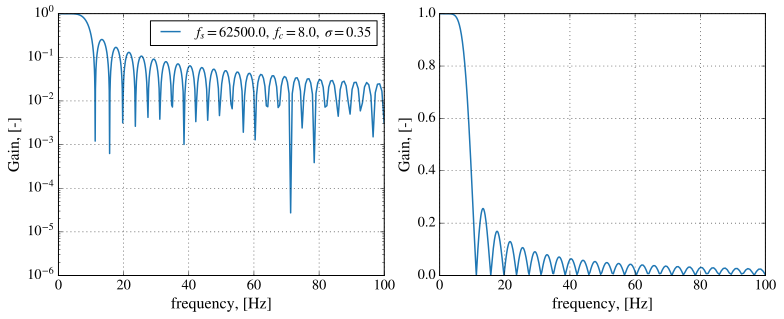

In [110]:
class constants:

    LP_fsample: int = 62500.0     # [Hz] - sampling rate  
    LP_window: int = 301      # [-] - window of the filter  
    LP_fc: float = 8.0       # [Hz] - estimated cutting frequency of the filter
    LP_sigma: float = 0.35    # [-] - slope of the filter 

consts = constants()

# LP_coefs = FilterSincGaussian( 1741, consts.LP_fc, consts.LP_sigma  )

high_filter_seq = array( [17419, 97, 91, 87, 83, 77 ] )#[1741,1691,1611,1551,1443,1333] )
high_b = filters_sym_6th( high_filter_seq )
PlotFilterSpecs( high_b[0], consts.LP_fsample, consts.LP_fc, consts.LP_sigma, "" )

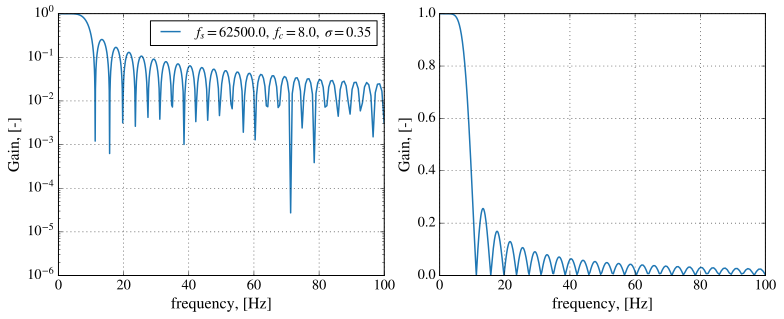

In [111]:
PlotFilterSpecs( high_b[0], consts.LP_fsample, consts.LP_fc, consts.LP_sigma, "" )

In [137]:
fc = 350.0

LP_coefs = FilterSincGaussian( 1741, fc, consts.LP_sigma  )
NT = LP_coefs.shape[0]

m  = int( ( NT-1 ) / 2 )
v =  np.linspace( -m, m, 2*m+1 )

eiwt = np.exp( 1J * 2.0 * np.pi * fc / NT * v )
G = np.dot( LP_coefs, eiwt )
H = np.abs( G )
fc, H, NT

(350.0, 0.5871297281158948, 1741)

In [124]:
def filter_multiply( filter, signal ):


  half_window = int( filter.size / 2 )

  if filter.size % 2 == 0:
    raise "ERROR@filter_multiply: filter size is even."

    out_signal = zeros( signal.size - 2*half_window )

    ej = filter.size;
    hw = ej / 2;
    ei = signal.size - 2*hw;

    for i in range( 0, ei ):
        out_signal[i] = dot( signal[i:i+ej], filter )

    return out_signal

In [85]:
#~#############################################################################
def filters_plot( bhigh, f_sample, numfig, clr='r' ):

  filter_name = []
  first = True
  figure( numfig )

  ax1 = subplot(111)
  ylabel( 'Amplitude' )
  xlabel( 'Frequency (Hz)' )
  grid()

  freqs = linspace( 0.0, 1.0 / 10.0, 62500 )
  nplot = len( freqs )

  wf = None
  hf = ones( nplot )

  for b in bhigh:
    n = b.size
    filter_name.append( n )
    a = zeros(n)
    a[ n // 2 ] = 1.0
    w, h = freqz( b, a, freqs )
    hf *= abs(h)

    ah  = 20 * log10( abs(h) )

    if first:
      # freq_filter = freq_normalized * freq_sample / ( 2 * pi )
      wf  = w.copy()
      wf *= f_sample / ( 2.0 * pi )

    # plot( wf, ah, 'b' if first else 'c', label=str(n) )
    first = False

  angles = unwrap( angle( hf ) )
  hf = 20 * log10( hf )

  semilogy( wf, hf, clr, label = 'filter' )
  ax1.legend(loc = 'lower right')

#   ax2 = ax1.twinx()
#   semilogy( wf, angles, 'm', label='phase' )

  title( ( 'Filter %s @ f_s = %.1f Hz' % ( str( filter_name ), f_sample ) ) )
#   ax2.legend(loc = 'upper right')
  ylabel('Phase angle (radians)', color='m')
#   xlim( (0,40) )

  return

#~#############################################################################
def filters_sym_6th( pnts_seq ):

  b_lst = []
  for Npts in pnts_seq:
    b = zeros( Npts )

    float_Npts = float( Npts )
    hpts = Npts / 2

    if Npts % 2 == 0:
      print( ' Number of points should be an odd ', Npts )
      exit(1)

    CONST6_0 = (   1225.E0*float_Npts**6 -  57575.E0*float_Npts**4 +  \
                 605395.E0*float_Npts**2 - 952245.E0 ) / 64.E0
    CONST6_2 = ( -11025.E0*float_Npts**4 + 330750.E0*float_Npts**2
               -1507485.E0 ) / 16.E0
    CONST6_4 = (  24255.E0*float_Npts**2 - 347655.E0 ) / 4.E0
    CONST6_6 = -15015.E0
    Denomi_6 =  4.E0 * float_Npts * ( float_Npts**6 - 56.E0*float_Npts**4
            + 784.E0*float_Npts**2 - 2304.E0 )

    mid_Coef = array( [ CONST6_0 / Denomi_6 ] )
    pl = array( [CONST6_6, 0.0, CONST6_4, 0.0, CONST6_2, 0.0, CONST6_0] )

    float_I = arange( 1.0, hpts + 0.1, 1.0 )

    Coefs = polyval( pl, float_I ) / Denomi_6

    lst = concatenate( ( Coefs[::-1], mid_Coef, Coefs ) )
    b_lst.append( lst )

    # for i in lst:
    #   print( lst)

  return b_lst

#~#############################################################################
def LS_fitting( time, signal, degree ):
  return poly1d( polyfit( time, signal, degree ) )

#~#############################################################################
def sym_filters_avg_ends( b_lst, y ):
  # average ends
  for b in b_lst:
    half_window = int( len(b) / 2 )

    # average seems to work well -> good first approach
    firstvals = ones( half_window ) * average( y[ 1: half_window+1] )
    lastvals  = ones( half_window ) * average( y[-half_window-1:-1] )

    # mirrors -> does not work very well...
    #~ firstvals = y[ 0] - abs( y[ 1: half_window+1][::-1] - y[ 0] )
    #~ lastvals  = y[-1] - abs( y[-half_window-1:-1][::-1] - y[-1] )

    y = concatenate( ( firstvals, y, lastvals ) )
    y = filter_multiply( b, y )

  return y

#~#############################################################################
def sym_filters_czo_ends( b_lst, y ):
  # continuous zero orders ends
  window = 4*len( b_lst[0] )

  half_window = 0
  for b in b_lst:
    half_window += int( len(b) / 2 )

  firstvals = ones( half_window ) * average( y[ :window] )
  lastvals  = ones( half_window ) * average( y[-window:] )
  y = concatenate( ( firstvals, y, lastvals ) )

  for b in b_lst:
    y = filter_multiply( b, y )

  return y

#~#############################################################################
def sym_filters_cls_ends( b_lst, y, ends_degree = 6, mult = 1 ):
  # continuous least-square ends
  for b in b_lst:
    window      = mult*len(b)
    half_window = int( len(b) / 2 )

    time        = arange( 0, window+0.5, 1.0 )

    left_time   = time[ :half_window ]
    left_y      = y[ : window + 1 ]
    poly_left   = LS_fitting( time, left_y,  ends_degree )
    left_vals   = poly_left ( left_time )

    right_time  = time[ -half_window: ]
    right_y     = y[ -window-1: ]
    poly_right  = LS_fitting( time, right_y, ends_degree )
    right_vals  = poly_right( right_time )

    y = filter_multiply( b, y )
    y = concatenate( ( left_vals, y, right_vals ) )

  return y

#~#############################################################################
def filters_SG2( pnts_seq, degree ):
  b_lst = []
  for Npts in pnts_seq:

    M = Npts / 2
    b = zeros( Npts )
    b[M+1] = 1
    q = linspace(-M,M,Npts)
    #~ print( len(b), len(q))

    a = polyfit(q, b,degree);

    h = polyval(a,q)

    if Npts % 2 == 0:
      print( ' Number of points should be an odd ', Npts )
      exit(1)

    b_lst.append( h )

  return b_lst

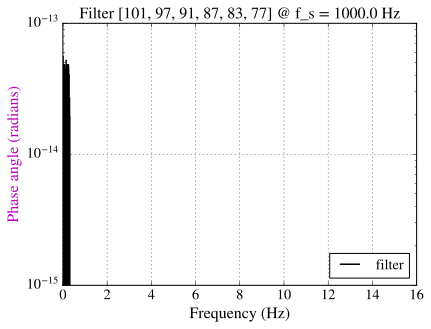

In [86]:

# f_sample = 62500.0
# high_filter_seq = array( [17419, 16603, 15787, 14971, 14155, 13315] )

f_sample = 1000.0
high_filter_seq = array( [101, 97, 91, 87, 83, 77 ] )#[1741,1691,1611,1551,1443,1333] )


high_b = filters_sym_6th( high_filter_seq )
bw = filters_plot( high_b, f_sample, 30, 'k' )
